<a href="https://colab.research.google.com/github/asgutierrt/Introduction-to-IA/blob/main/neural_networks/notebooks/main_mlp_sympy_v2_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# funciones


In [2]:
# requerimientos
import os
import numpy as np
from sympy import *
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

class MLP:
  __slots__ = ['conf','w_dict']
  def __init__(self,layers_setup,bias=None):
    if bias is None: bias=dict.fromkeys(range(len(layers_setup)),0)
    self.conf={}; self.w_dict={}; entrada=None
    for layer,(neuronas,phi) in enumerate(layers_setup):
      if entrada is None: entrada=Matrix(symarray('X', neuronas))
      self.conf[layer]=layer_obj(entrada,neuronas,phi,bias[layer])
      self.w_dict[layer]=self.conf[layer].W
      entrada=self.conf[layer].Y

  def frwd_eval(self,w_dict,x):
    entrada=x
    for layer in range(len(self.conf)):
      self.conf[layer].update_w(w_dict[layer],entrada)
      entrada=self.conf[layer].Y

  def sympy_frwd_eval(self,w_dict,n_x):
    entrada=Matrix(symarray('X', n_x))
    for layer in range(len(self.conf)):
      self.conf[layer].update_w(w_dict[layer],entrada)
      entrada=self.conf[layer].Y

class layer_obj:
  __slots__ = ['m','phi','bias','x','W','V','Y','dY_dV']
  def __init__(self,x,m,phi,bias):
    self.m=m; self.phi=phi; self.bias=bias # estaticos
    self.x=x; self.W=Matrix(np.random.rand(m,int(x.shape[0]))*np.sqrt(2/m)) # inicializar variables w para la capa
    self.frwd_eval(m,phi)

  def frwd_eval(self,m,phi):
    self.V=self.W*self.x +np.ones((m,1))*self.bias # campo local inducido en cada perceptron
    # funcion de activacion evaluada en el campo de los m perceptrones
    self.Y=Matrix(m,1, lambda i,j: phi.subs({"v":self.V[i,j]}))
    # derivada de la funcion de activacion evaluada en el campo
    self.dY_dV=Matrix(m,1, lambda i,j: diff(phi,"v").subs({"v":self.V[i,j]}))

  def update_w(self,w,x):
    self.W=w; self.x=x
    self.frwd_eval(self.m,self.phi)

def grad_descent(X,Y_d,model,epocas=5,eta=1,tol=0,fig=None):
  layers_labels=sorted(model.conf.keys(),reverse=True) # orden para backpropagation
  # almacenar informacion de cada iteracion
  local_grads={layer:[] for layer in layers_labels}; avrg_error=[]
  pbar = tqdm(total=len(X)*epocas*len(layers_labels)) # create progress bar
  iteracion=0; grad_dead_at=None
  while iteracion < len(X)*epocas:
    p=iteracion%len(X); iteracion+=1
    model.frwd_eval(model.w_dict,X[p]) # forward evaluation
    # backward evaluation
    init_local_grad=None
    for layer in layers_labels:
      # calculate gradient
      if init_local_grad is None:
        e=Y_d[p].reshape((-1,1))-model.conf[layer].Y
        avrg_error.append((e.T*e)[0]/2)
        init_local_grad=-1*e
      local_grad=init_local_grad.multiply_elementwise(model.conf[layer].dY_dV)
      dJ_dw=local_grad*model.conf[layer].x.T
      init_local_grad=model.conf[layer].W.T*local_grad
      # update w vals in layer
      model.w_dict[layer]+=eta*dJ_dw
      # save local gradients
      local_grads[layer].append(list(local_grad))
      pbar.update(1) # update progress bar

    # plot 10 init iterations
    if fig and iteracion<10:
      Layers=len(layers_labels)
      Y_pred=[list(model.conf[Layers-1].Y.xreplace(dict(zip(model.conf[Layers-1].Y.free_symbols,xp)))) for xp in X]
      output_k=0; plt.plot([x[output_k] for x in Y_pred])

    # guardar en que iteracion muere el gradiente
    window_size=int(len(X)*0.1)
    if grad_dead_at is None and iteracion>window_size and all([(np.absolute(np.diff(np.mean(local_grads[layer][-window_size:],axis=1),n=1))<tol).all() for layer in layers_labels]):
      grad_dead_at=iteracion
    # detenerse solo despues de la primera epoca
    if grad_dead_at and iteracion>grad_dead_at+window_size:
      pbar.close()
      print("gradients died first at iteration %i"%grad_dead_at)
      break
  return local_grads, avrg_error, grad_dead_at


################## support functions
def process_exp(model_label,model,local_grads,avrg_error,grad_dead_at,n,L,start,X_test,Y_d_test,dfs,csv_path):
  # unpack dfs
  predictions,w_vals,energia_error,error,deltas,avrg_delta=dfs
  # error en test
  model.sympy_frwd_eval(model.w_dict,n)
  Y_pred=[list(model.conf[L+1].Y.xreplace(dict(zip(model.conf[L+1].Y.free_symbols,xp)))) for xp in X_test]
  test_errors=np.mean([sum(e**2)/2 for e in (Y_d_test-Y_pred)])
  predictions[model_label]=Y_pred
  predictions.to_csv(csv_path+"/predictions.csv")
  # guardar informacion del entrenamiento
  for layer,ws in model.w_dict.items(): w_vals.loc[model_label,layer]=ws
  w_vals.to_csv(csv_path+"/w_vals.csv")
  energia_error,error,deltas,avrg_delta=guardar_informacion(model_label,csv_path,
                                                            avrg_error,local_grads,test_errors,
                                                            [energia_error,error,deltas,avrg_delta],
                                                            start,grad_dead_at)
  return predictions,w_vals,energia_error,error,deltas,avrg_delta

def guardar_informacion(model_label,csv_path,avrg_error,local_grads,test_errors,dfs,start,grad_dead_at):
  energia_error,error,deltas,avrg_delta=dfs
  # guardar informacion
  end=time.time()
  # energia error
  df_error=pd.DataFrame(avrg_error,columns=pd.MultiIndex.from_tuples([('error',)+model_label]),dtype=float)
  energia_error=pd.concat([energia_error,df_error], axis=1)
  energia_error.to_csv(csv_path+"/energia_errores.csv")

  # error en entrenamiento
  error.loc[model_label,'train error']=df_error.mean().values[0]
  # error en test
  error.loc[model_label,'test error']=test_errors
  error.loc[model_label,'time [s]']=end-start

  # local gradients
  cols_label=lambda layer, neurons: pd.MultiIndex.from_tuples([("$\\delta_%s$"%layer,)+model_label+('neuron %i'%i,) for i in neurons])
  info_delta=lambda grad_info,layer: pd.DataFrame(grad_info,dtype=float,columns=cols_label(layer,range(len(grad_info[0]))))
  df_local_grads=pd.concat([info_delta(local_grads[layer],layer) for layer in pd.DataFrame(local_grads)],axis=1)
  deltas[df_local_grads.columns]=df_local_grads
  deltas.to_csv(csv_path+"/deltas.csv")

  # mean local gradients
  df_mean=df_local_grads.groupby(level=[0,1,2,3],axis=1).mean()
  avrg_delta[df_mean.columns]=df_mean
  avrg_delta.to_csv(csv_path+"/avrg_deltas.csv")

  # estabilizacion
  df_stable_mean=df_local_grads.iloc[grad_dead_at:].groupby(level=[0],axis=1).mean()
  error.loc[model_label,df_stable_mean.columns]=df_stable_mean.mean(axis=0)[df_stable_mean.columns]
  error.loc[model_label,'gradient death i']=grad_dead_at
  error.to_csv(csv_path+"/errores_train_test.csv")
  return energia_error, error, deltas, avrg_delta

def graficar_df(df,layout,y_label,x_label,title,rot=0,figsize=(7,4),name='',path=''):
  dim_names=set(df.columns.get_level_values(0))
  fig_x,fig_y= (1,len(dim_names)) if layout=="h" else (len(dim_names),1)
  fig, ax = plt.subplots(fig_x,fig_y,figsize=figsize,sharex=True,squeeze=False)
  labels=None
  for i, (dimension, df_) in enumerate(df.groupby(level=0,axis=1)):
    ix,iy= (0,i) if layout=="h" else (i,0)
    labels_i=df_[dimension].columns.tolist()
    df_.plot(ax=ax[ix,iy],style=["-"]*(len(labels_i)-1)+['-'],rot=rot,legend=False)
    ax[ix,iy].set_ylabel(y_label(i))
    ax[ix,iy].set_xlabel(x_label)
    if labels is None: labels=labels_i
  fig.suptitle(title,y=1)
  fig.legend(labels,bbox_to_anchor=[0.5, 0.97],loc='upper center',ncol=12,fontsize="small",alignment='left')
  fig.tight_layout(); plt.savefig(path+'/%s.png'%name)

def graficar_Y(Y_d_test,predictions,figs,model_names,title,fig_path):
    fig = plt.figure(figsize=(8,5))
    plt.plot(Y_d_test)
    for name in model_names:
        Y_pred=predictions[name]; output_k=0
        plt.plot(Y_pred.str[output_k])
    fig.legend(['Y real']+[model+" "+str(name) for model,name in zip(figs,model_names)],
            bbox_to_anchor=[0.98, 0.899],loc='upper right')
    fig.suptitle(title);fig.tight_layout();plt.savefig(fig_path)

def load_data(data_path,fig_path=False):
    File_data = pd.read_csv(data_path, sep=",", header=None)
    File_data = 2*(File_data/np.max(File_data,axis=0))-1 # normalizar a [-1,1]

    # muestrear
    n_data=len(File_data)
    ix=np.random.choice(n_data, n_data, replace=False)
    n_train=int(n_data*0.6); n_test=int(n_data*0.2); n_val=int(n_data*0.2)

    # sort data
    data_train=File_data.loc[ix[:n_train]]
    data_test=File_data.loc[ix[n_train:n_train+n_test]].sort_index()
    data_val=File_data.loc[ix[-n_val:]].sort_index()

    # split data
    col_x=[0,1]; col_y=[2]
    X = data_train[col_x].to_numpy(); Y_d = data_train[col_y].to_numpy()
    X_test=data_test[col_x].to_numpy(); Y_d_test = data_test[col_y].to_numpy()
    X_val=data_val[col_x].to_numpy(); Y_d_val = data_val[col_y].to_numpy()

    # plot
    fig, ax=plt.subplots(figsize=(12,5))
    data_train.sort_index().plot(style='.',markersize=0.5,color='y',ax=ax)
    data_test.plot(style='.',markersize=0.5,color='g',ax=ax)
    data_val.plot(style='.',markersize=0.5,color='r',ax=ax)

    # format figure
    vars=[("x1",0),('x2',1),('y',2)]; annotate=data_test.iloc[-1]
    for x,ix in vars: ax.annotate(x,(annotate.name,annotate[ix]))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::int(len(labels)/3)], ['train','test','validation'])
    plt.savefig(fig_path+'/inputs.png')
    return X,Y_d,X_test,Y_d_test,X_val,Y_d_val

In [3]:
def grad_descent_batch(X,Y_d,model,epocas=5,eta=1,tol=0,fig=None):
  layers_labels=sorted(model.conf.keys(),reverse=True) # orden para backpropagation
  n=len(X[0]); m=len(Y_d[0])
  # almacenar informacion de cada iteracion
  local_grads={layer:[] for layer in layers_labels}; avrg_errors=[]
  pbar = tqdm(total=epocas) # create progress bar
  iteracion=0; grad_dead_at=None
  while iteracion < epocas:
    init_local_grad=None; iteracion+=1
    for layer in layers_labels:
      # calculate gradient
      if init_local_grad is None:
        # avrg error en batch
        model.sympy_frwd_eval(model.w_dict,n)
        Y_pred=[list(model.conf[layer].Y.xreplace(dict(zip(model.conf[layer].Y.free_symbols,xp)))) for xp in X]
        errors=np.array([sum(e**2)/2 for e in (Y_d-Y_pred)])
        worst_pred=X[errors.argmax()]
        avrg_error=errors.mean(); avrg_errors.append(avrg_error)
        # forward eval on worst prediction
        model.frwd_eval(model.w_dict,worst_pred)
        init_local_grad=-1*Matrix([avrg_error]*m)
      local_grad=init_local_grad.multiply_elementwise(model.conf[layer].dY_dV)
      dJ_dw=local_grad*model.conf[layer].x.T
      init_local_grad=model.conf[layer].W.T*local_grad
      # update w vals in layer
      model.w_dict[layer]+=eta*dJ_dw
      # save local gradients
      local_grads[layer].append(list(local_grad))
      pbar.update(1) # update progress bar
    # plot iterations
    if fig and iteracion<10:
      output_k=0; plt.plot([x[output_k] for x in Y_pred])
    # guardar en que epoca muere el gradiente
    window_size=int(epocas*0.1)
    if grad_dead_at is None and iteracion>window_size and all([(np.absolute(np.diff(np.mean(local_grads[layer][-window_size:],axis=1),n=1))<tol).all() for layer in layers_labels]):
      grad_dead_at=iteracion
    # detenerse solo despues de la primera epoca
    if grad_dead_at and iteracion>grad_dead_at+window_size:
      pbar.close()
      print("gradients died first at iteration %i"%grad_dead_at)
      break
  return local_grads, avrg_errors, grad_dead_at

# cargar datos

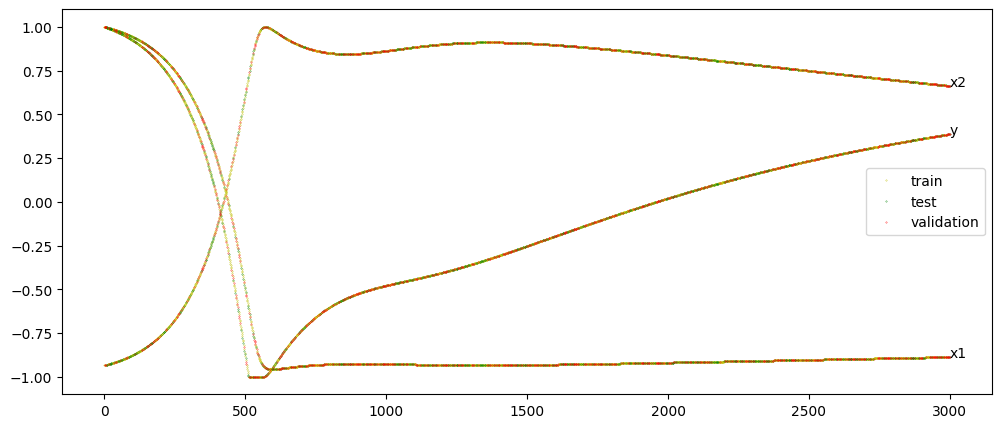

In [9]:
# paths para guardar resultados
fig_path = "figures"#os.path.join(os.path.dirname(os.path.abspath(__file__)), r'figures')
csv_path = "resultados"#os.path.join(os.path.dirname(os.path.abspath(__file__)), r'resultados')
if not os.path.exists(fig_path): os.makedirs(fig_path)
if not os.path.exists(csv_path): os.makedirs(csv_path)

# cargar archivo
## load data
data_path='https://raw.githubusercontent.com/asgutierrt/Introduction-to-IA/main/neural_networks/bacterial_growth.txt'
X,Y_d,X_test,Y_d_test,X_val,Y_d_val=load_data(data_path,fig_path)

## funciones de activacion
a=1; b=0; v = symbols("v")
phi_1=a*v+b # lineal
phi_tanh=(exp(v)-exp(-v))/(exp(v)+exp(-v)) # tanh
phi_sigmoid=1/(1+exp(-v)) # sigmoid

# inicializar df para guardar resultados
model_label_info=['layers', 'neurons', 'eta']
error=pd.DataFrame(columns=model_label_info).set_index(model_label_info)
energia_error=pd.DataFrame();
my_index = pd.MultiIndex(levels=[[]]*5,codes=[[]]*5,names=['layer','L','li','eta','neuron'])
deltas=pd.DataFrame(index=[],columns=my_index)
avrg_delta=pd.DataFrame(index=[],columns=my_index.droplevel(-1))
predictions=pd.DataFrame()
w_vals=pd.DataFrame(columns=model_label_info).set_index(model_label_info).astype(object)

In [ ]:
k=0.8
phi_sigmoid=1/(1+exp(-k*v)) # sigmoid
phi_tanh=(exp(k*v)-exp(-k*v))/(exp(k*v)+exp(-k*v)) # tanh

# corridas: trabajo NN

In [ ]:
## experimentacion
epocas=1; tol=10**-3
n=len(X[0]); m=len(Y_d[0])
dfs=[predictions,w_vals,energia_error,error,deltas,avrg_delta]
for L in [1,2,3]:
    bias=dict([(key,0) for key in range(1,L+1)]+[(0,1),(L+1,1)])
    for eta in [0.9,0.5,0.2]:
        exp_name="L=%i eta=%.2f"%(L,eta) # experiment identifier
        print('running ',exp_name)
        for mj in [1,2,3,4,5]:
            model_label=('L=%i'%L, '$l_i$=%i'%mj,'$eta=%.2f$'%eta)
            start=time.time()
            # initialize model
            model=MLP([(2,phi_tanh)]+[(mj,phi_1)]*L+[(1,phi_tanh)],bias)# init model on random sol
            # descenso por el gradiente
            local_grads,avrg_error,grad_dead_at=grad_descent(X,Y_d,model,epocas=epocas,eta=eta,tol=tol)
            # guardar informacion del entrenamiento
            dfs=process_exp(model_label,model, local_grads,avrg_error,grad_dead_at, n,L,start,X_test,Y_d_test,dfs,csv_path)
        # visualizaciones de cada experimento
        args_exp={'key':("L=%i"%L,'$eta=%.2f$'%eta), 'level':[1,3],'axis':1}
        avrg_delta=dfs[-1] # unpack avrg_delta
        graficar_df(avrg_delta.xs(**args_exp),'v',lambda i: "avrg $\\delta_%s$"%i,
                    'iteration (0-N*epochs)',"average local gradient progression - %s"%exp_name,
                    rot=0,figsize=(12,6),name='fig_avrg_delta_%s'%exp_name.replace(" ", "_"),path=fig_path)

# guardar resultados de cada experimento
predictions,w_vals,energia_error,error,deltas,avrg_delta=dfs

# corridas individuales

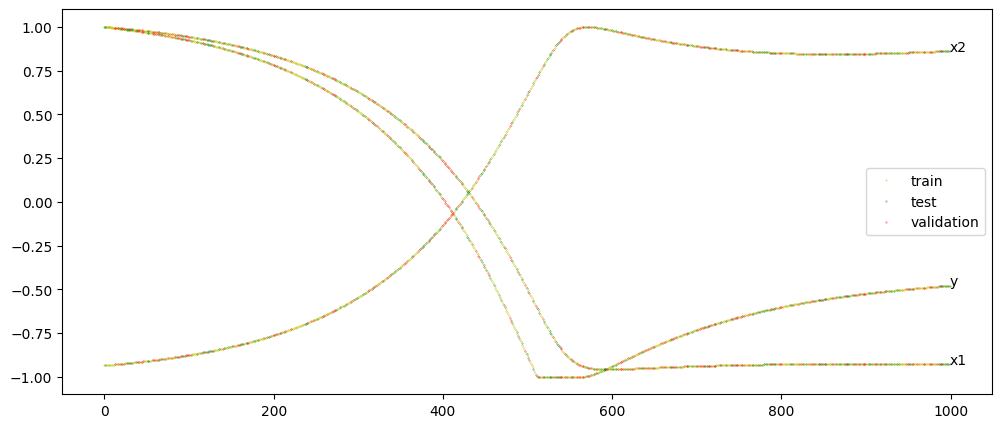

In [ ]:
np.random.seed(46)
X,Y_d,X_test,Y_d_test,X_val,Y_d_val=load_data(data_path,fig_path)

In [ ]:
import time
import copy

# setup
start=time.time()
L=0;mj=4
epocas=5; eta=0.9; tol=10**-3

# run exp
n=len(X[0]); m=len(Y_d[0])
dfs=[predictions,w_vals,energia_error,error,deltas,avrg_delta]

## init model
model_label=('L_tlt=%i'%L,'$l_i$=%i'%mj,'$eta=%.2f$'%eta)
bias=dict([(key,0) for key in range(1,L+1)]+[(0,0),(L+1,1)])
model=MLP([(2,phi_1)]+[(mj,phi_1)]*L+[(1,phi_tanh)],bias)# init model on random sol
## descenso por el gradiente
local_grads,avrg_errors,grad_dead_at=grad_descent(X,Y_d,model,epocas=epocas,eta=eta,tol=tol)
# guardar informacion del entrenamiento
dfs=process_exp(model_label,model, local_grads,avrg_errors,grad_dead_at, n,L,start,X_test,Y_d_test,dfs,csv_path)
predictions,w_vals,energia_error,error,deltas,avrg_delta=dfs

  0%|          | 0/18000 [00:00<?, ?it/s]

gradients died first at iteration 8363


# visualizar resultados en df

train error         test error    time [s]  \
layers  neurons eta                                                      
L_tlt=0 $l_i$=1 $eta=0.50$     0.845409  0.817237436076554  152.987485   
        $l_i$=4 $eta=0.50$     0.845110  0.817182919784833  154.260851   
                $eta=0.90$     0.847103  0.817808669706721  139.273386   
L_tlt=1 $l_i$=1 $eta=0.50$     0.654933  0.663053308401890   18.366304   
        $l_i$=2 $eta=0.50$     0.657294  0.672701992078628   10.571402   
                $eta=0.90$     0.657303  0.662692907285649    9.101367   

                            $\delta_0$  $\delta_1$  $\delta_2$  \
layers  neurons eta                                              
L_tlt=0 $l_i$=1 $eta=0.50$    0.002174    0.001028         NaN   
        $l_i$=4 $eta=0.50$    0.001008    0.001158         NaN   
                $eta=0.90$   -0.005611   -0.001578         NaN   
L_tlt=1 $l_i$=1 $eta=0.50$    0.000194    0.000149    0.000103   
        $l_i$=2 $eta=0.50$    0.000293    0.000169    0.000145   
                $eta=0.90$    0.000204    0.000137    0.000105   

                            gradient death i  
layers  neurons eta                           
L_tlt=0 $l_i$=1 $eta=0.50$               NaN  
        $l_i$=4 $eta=0.50$               NaN  
                $eta=0.90$            8363.0  
L_tlt=1 $l_i$=1 $eta=0.50$             759.0  
        $l_i$=2 $eta=0.50$             400.0  
                $eta=0.90$             282.0

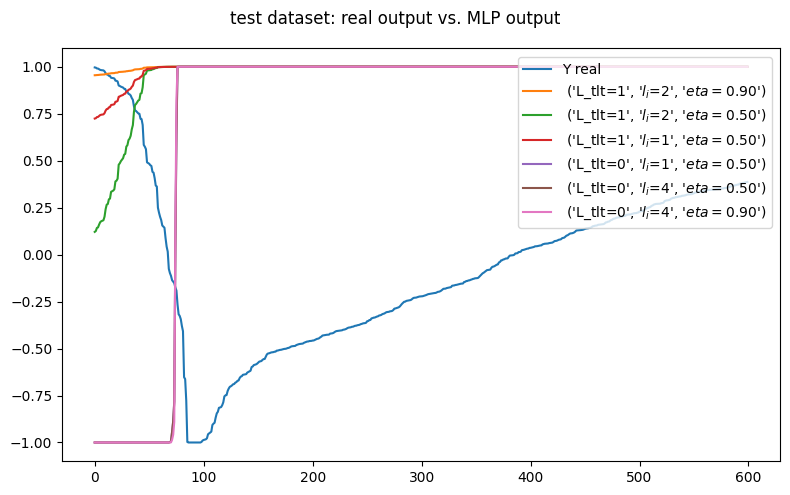

In [ ]:
# plot all
model_names=error.index.to_list()
figs=['']*len(model_names)

## plot outputs
graficar_Y(Y_d_test,predictions,figs,model_names,
        "test dataset: real output vs. MLP output",fig_path+'/outputs.png')
## errors
display(error.loc[model_names].sort_index())

<ipython-input-41-f66ea60a0961>:156: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_.plot(ax=ax[ix,iy],style=["-"]*(len(labels_i)-1)+['-'],rot=rot,legend=False)


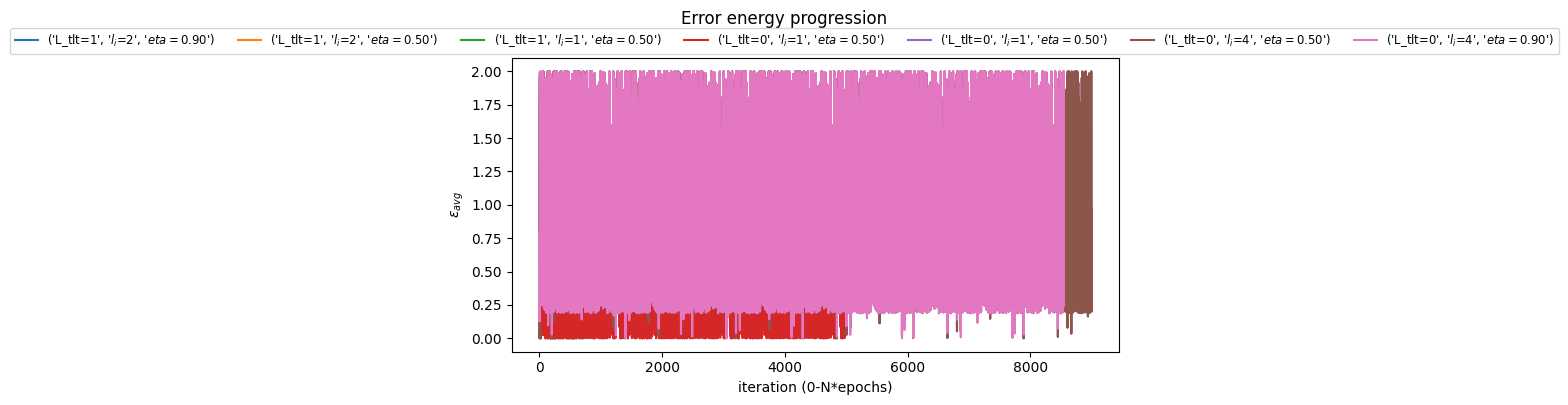

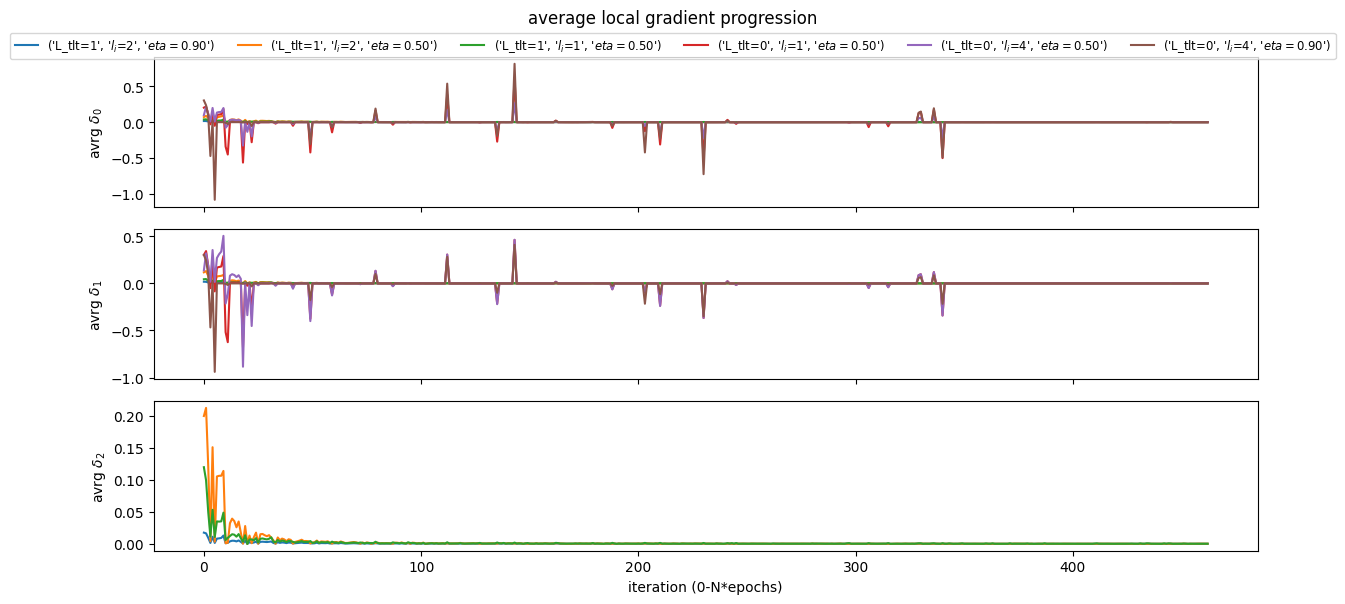

In [ ]:
## plot error energy
filter=[x[1:] in model_names for x in energia_error.columns]
graficar_df(energia_error.loc[:,filter],'v',lambda i: "$\\varepsilon_{avg}$",
            'iteration (0-N*epochs)',"Error energy progression",rot=0,
            name='error_energy',path=fig_path)
## plot avrg local gradients
filter=[x[1:] in model_names for x in avrg_delta.columns]
graficar_df(avrg_delta.loc[:,filter],'v',lambda i: "avrg $\\delta_%s$"%i,
            'iteration (0-N*epochs)',"average local gradient progression",
            rot=0,figsize=(12,6),name='avrg_delta',path=fig_path)

In [ ]:
'''
# paths para guardar resultados
fig_path = "figures"#os.path.join(os.path.dirname(os.path.abspath(__file__)), r'figures')
csv_path = "resultados"#os.path.join(os.path.dirname(os.path.abspath(__file__)), r'resultados')
if not os.path.exists(fig_path): os.makedirs(fig_path)
if not os.path.exists(csv_path): os.makedirs(csv_path)

# cargar archivo datos
data_path="final.txt"
X,Y_d,X_test,Y_d_test,X_val,Y_d_val=load_data(data_path)
n=len(X[0]); m=len(Y_d[0])

import ast
error=pd.read_csv("errores_train_test.csv",index_col=[0,1,2])
energia_error=pd.read_csv("energia_errores.csv",header=[0,1,2,3],index_col=0)
avrg_delta=pd.read_csv("avrg_deltas.csv",header=[0,1,2,3],index_col=0)
predictions=pd.read_csv("predictions.csv",index_col=0).applymap(lambda x: [float(val) for val in x.strip('][').split(',')])
predictions.columns=[ast.literal_eval(x) for x in predictions.columns]
w_vals=pd.read_csv("w_vals.csv",index_col=[0,1,2]).applymap(lambda x: sympify(x) if type(x)!=float else np.nan)
w_vals.columns=[int(x) for x in w_vals.columns]

In [ ]:

## selection criteria
criteria=["test error"]
figs=['best mlp','worst mlp','avrg mlp']
error.sort_values(by=criteria, inplace=True)
model_names=[error[error[criteria]==error[criteria].min()].dropna(how='all').index[0],
            error[error[criteria]==error[criteria].max()].dropna(how='all').index[0],
            error[error[criteria] >= error[criteria].mean()].dropna(how='all').iloc[0].name]

In [ ]:
## validation error
for model_label in model_names:
  L=int(model_label[0][-1]); mj=int(model_label[1][-1])
  eta=float(model_label[2].rsplit("=")[1].split('$')[0])
  model=MLP([(n,phi_sigmoid)]+[(mj,phi_sigmoid)]*L+[(m,phi_sigmoid)])# init model on random sol
  # error en validacion
  model.sympy_frwd_eval(w_vals.loc[model_label].dropna().to_dict(),n)
  Y_pred=[list(model.conf[L+1].Y.xreplace(dict(zip(model.conf[L+1].Y.free_symbols,xp)))) for xp in X_val]
  val_errors=np.mean([sum(e**2)/2 for e in (Y_d_val-Y_pred)])
  error.loc[model_label,'val error']=val_errors

por batch

In [ ]:
1. propagar
2. punto de mayor error y error promedio para retropropagar
3. aleatoriamente tomar un punto


**minimizar entropia**